# Video Game Sales Prediction Pipeline
**Developers:** Kylen Bregula, Isaiah Herard, Lazaro Loureiro


**Description:** 

This notebook performs a complete pipeline for predicting global video game sales, including:
- Data loading
- Cleaning & preprocessing
- Feature engineering
- Exploratory Data Analysis (EDA)
- Model training & evaluation
- Saving results and models


# Imports and Warnings
This cell imports all necessary Python libraries for data manipulation, visualization, and machine learning. Warnings are suppressed for cleaner output.


In [117]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Data manipulation and numerical computing
import pandas as pd       # For dataframes and data analysis
import numpy as np        # For numerical operations

# Visualization libraries
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns             # For statistical data visualization

# Scikit-learn imports for machine learning
from sklearn.model_selection import train_test_split, KFold, cross_val_score  
# - train_test_split: split data into train/test sets
# - KFold: for cross-validation
# - cross_val_score: compute cross-validated scores for models

from sklearn.pipeline import Pipeline  # To create modeling pipelines
from sklearn.compose import ColumnTransformer  # To apply transformations to subsets of features
from sklearn.impute import SimpleImputer      # To handle missing values
from sklearn.preprocessing import StandardScaler, OneHotEncoder  
# - StandardScaler: scale numeric features
# - OneHotEncoder: encode categorical features

from sklearn.linear_model import LinearRegression      # Linear regression model
from sklearn.tree import DecisionTreeRegressor          # Decision tree regression
from sklearn.ensemble import RandomForestRegressor      # Random forest regression

# Metrics for evaluating model performance
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error  
# - r2_score: coefficient of determination
# - root_mean_squared_error: RMSE
# - mean_absolute_error: MAE


# Constants
Defines important constants for file paths, random seeds, train/test/validation split ratios, and number of cross-validation folds.


In [118]:
DATA_FILENAME = r"c:\Users\lazar\Machine learning project\Machine-Learning-Project\Video_Games_Sales.csv"  # Input dataset file
RESULTS_CSV = "model_results.csv"        # File to save model evaluation results
RANDOM_STATE = 1958                      # Seed for reproducibility also the year of first video game ever made!
TEST_SIZE = 0.15                         # Proportion of data for the test set (15%)
VAL_SIZE = 0.1765                        # Proportion of train_val used as validation (15/85 = 0.1765 for 70/15/15 split)
N_FOLDS = 5                              # Number of folds for K-Fold cross-validation

# Evaluation Functions
Functions to calculate R², RMSE, and MAE metrics for model evaluation.


In [119]:
def rmse(y_true, y_pred):
    """
    Compute Root Mean Squared Error (RMSE)
    
    Parameters:
    y_true : array-like of true target values
    y_pred : array-like of predicted values
    
    Returns:
    float : RMSE
    """
    return root_mean_squared_error(y_true, y_pred)

def evaluate(y_true, y_pred):
    """
    Evaluate model predictions using R², RMSE, and MAE
    
    Parameters:
    y_true : array-like of true target values
    y_pred : array-like of predicted values
    
    Returns:
    dict : Dictionary with 'r2', 'rmse', 'mae' metrics
    """
    return {
        "r2": r2_score(y_true, y_pred),
        "rmse": rmse(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred)
    }


# Load Data
Loads the dataset from a CSV file and displays the first few rows to inspect the data.


In [120]:
# Load the dataset
df = pd.read_csv(DATA_FILENAME)

# Display the shape of the dataset
print(f"Original rows: {df.shape[0]}, columns: {df.shape[1]}")

# Display the first 5 rows
df.head()


Original rows: 16719, columns: 16


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


# Data Quality Assessment
Analyze missing values, data types, and basic statistics to understand data quality.

**Report Tables (Exact Labels):**
- Table 1: Descriptive Statistics — Key Numeric Variables
- Table 2: Missing Values by Variable

In [121]:
# === TABLE 1: Descriptive Statistics for Key Numeric Variables ===
print("=" * 80)
print("TABLE 1: Summary of Descriptive Statistics for Key Numeric Variables")
print("=" * 80)

numeric_cols = ['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 
                'Other_Sales', 'Global_Sales', 'Critic_Score', 'Critic_Count', 
                'User_Score', 'User_Count']

desc_stats = df[numeric_cols].describe().T
desc_stats['missing'] = df[numeric_cols].isnull().sum()
desc_stats['missing_pct'] = (desc_stats['missing'] / len(df) * 100).round(2)

# Reorder columns for better readability
desc_stats = desc_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing', 'missing_pct']]
print(desc_stats.to_string())
print("\n")

# === TABLE 2: Missing Value Percentages by Variable ===
print("=" * 80)
print("TABLE 2: Missing Value Percentages by Variable")
print("=" * 80)

missing_data = pd.DataFrame({
    'Variable': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2),
    'Data_Type': df.dtypes
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
print(missing_data.to_string(index=False))
print("\n")

# === Data Type Summary ===
print("=" * 80)
print("DATA TYPE SUMMARY")
print("=" * 80)
print(df.dtypes.value_counts())
print(f"\nTotal Rows: {len(df):,}")
print(f"Total Columns: {len(df.columns)}")
print(f"Duplicate Rows: {df.duplicated().sum()}")

TABLE 1: Summary of Descriptive Statistics for Key Numeric Variables
                   count         mean         std      min      25%      50%      75%       max  missing  missing_pct
Year_of_Release  16450.0  2006.487356    5.878995  1980.00  2003.00  2007.00  2010.00   2020.00      269         1.61
NA_Sales         16719.0     0.263330    0.813514     0.00     0.00     0.08     0.24     41.36        0         0.00
EU_Sales         16719.0     0.145025    0.503283     0.00     0.00     0.02     0.11     28.96        0         0.00
JP_Sales         16719.0     0.077602    0.308818     0.00     0.00     0.00     0.04     10.22        0         0.00
Other_Sales      16719.0     0.047332    0.186710     0.00     0.00     0.01     0.03     10.57        0         0.00
Global_Sales     16719.0     0.533543    1.547935     0.01     0.06     0.17     0.47     82.53        0         0.00
Critic_Score      8137.0    68.967679   13.938165    13.00    60.00    71.00    79.00     98.00     8582 

# Data Cleaning & Feature Engineering
Cleans the dataset by handling missing values, converting columns to numeric types, consolidating publishers, creating new features like Decade and Publisher_reduced, and transforming the target variable with log1p.


In [122]:
def clean_and_engineer(df):
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]
    df = df.replace(r'^\s*$', np.nan, regex=True)

    # Standardize text columns
    text_cols = ["Publisher", "Developer", "Genre", "Platform", "Rating", "Name"]
    for c in text_cols:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip().replace({"nan": np.nan})

    # Map known Publisher variations to ensure consistency
    if "Publisher" in df.columns:
        pub_map = {
            "Ea Sports": "Electronic Arts",
            "Ea": "Electronic Arts",
            "Electronic Arts Inc.": "Electronic Arts",
            "Nintendo Epd": "Nintendo",
            "Nintendo E": "Nintendo"
        }
        df["Publisher"] = df["Publisher"].replace(pub_map)

    # Convert numeric columns to proper types
    numeric_cols = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales",
                    "Global_Sales", "Critic_Score", "Critic_Count",
                    "User_Score", "User_Count", "Year_of_Release"]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Handle special cases for User_Score ("tbd" values)
    if "User_Score" in df.columns:
        df["User_Score"] = df["User_Score"].replace({"tbd": np.nan})

    # Drop rows with missing Global_Sales (target variable)
    if "Global_Sales" in df.columns:
        df = df.dropna(subset=["Global_Sales"])

    # Drop duplicates
    df = df.drop_duplicates()

    # === MISSING VALUE HANDLING (Per Report Specifications) ===
    impute_values = {}
    
    # Impute Year_of_Release with median
    if "Year_of_Release" in df.columns:
        median_year = int(df["Year_of_Release"].median(skipna=True))
        df["Year_of_Release"] = df["Year_of_Release"].fillna(median_year).astype(int)
        impute_values["Year_of_Release"] = median_year
    
    # Impute Critic_Score with median
    if "Critic_Score" in df.columns:
        median_critic = float(df["Critic_Score"].median(skipna=True))
        df["Critic_Score"] = df["Critic_Score"].fillna(median_critic)
        impute_values["Critic_Score"] = median_critic
    
    # Impute Critic_Count with median
    if "Critic_Count" in df.columns:
        median_critic_count = float(df["Critic_Count"].median(skipna=True))
        df["Critic_Count"] = df["Critic_Count"].fillna(median_critic_count)
        impute_values["Critic_Count"] = median_critic_count
    
    # Impute User_Score with median
    if "User_Score" in df.columns:
        median_user = float(pd.to_numeric(df["User_Score"], errors="coerce").median(skipna=True))
        df["User_Score"] = df["User_Score"].fillna(median_user)
        impute_values["User_Score"] = median_user
    
    # Impute User_Count with median
    if "User_Count" in df.columns:
        median_user_count = float(df["User_Count"].median(skipna=True))
        df["User_Count"] = df["User_Count"].fillna(median_user_count)
        impute_values["User_Count"] = median_user_count
    
    # Fill categorical variables with "Unknown" (per report)
    if "Publisher" in df.columns:
        df["Publisher"] = df["Publisher"].fillna("Unknown")
    if "Developer" in df.columns:
        df["Developer"] = df["Developer"].fillna("Unknown")
    if "Rating" in df.columns:
        df["Rating"] = df["Rating"].fillna("Unknown")

    # === OUTLIER HANDLING (IQR Method at 95th percentile per Report) ===
    if "Global_Sales" in df.columns:
        # Cap outliers at 95th percentile as per report
        Q95 = df["Global_Sales"].quantile(0.95)
        df["Global_Sales"] = df["Global_Sales"].clip(upper=Q95)
        impute_values["Global_Sales_Q95"] = Q95

    # Feature engineering: Decade
    if "Year_of_Release" in df.columns:
        df["Decade"] = (df["Year_of_Release"] // 10) * 10

    # Reduce Publisher categories (top 30 + Other)
    if "Publisher" in df.columns:
        top_n = 30
        top_publishers = df["Publisher"].value_counts().nlargest(top_n).index
        df["Publisher_reduced"] = df["Publisher"].where(df["Publisher"].isin(top_publishers), other="Other")

    # Compute regional sales percentages
    for col in ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]:
        if col in df.columns and "Global_Sales" in df.columns:
            df[f"{col}_pct"] = df[col] / df["Global_Sales"]

    # Log-transform Global_Sales (for modeling)
    df["Global_Sales_log1p"] = np.log1p(df["Global_Sales"])

    return df, impute_values

# Clean and engineer the dataset
df_clean, impute_values = clean_and_engineer(df)
print(f"Rows after cleaning: {df_clean.shape[0]}, columns: {df_clean.shape[1]}")
impute_values


Rows after cleaning: 16719, columns: 23


{'Year_of_Release': 2007,
 'Critic_Score': 71.0,
 'Critic_Count': 21.0,
 'User_Score': 7.5,
 'User_Count': 24.0,
 'Global_Sales_Q95': np.float64(2.04)}

# Outlier Detection
Identify and visualize outliers in Global_Sales using boxplots and IQR method.

**Report Tables & Visuals (Exact Labels):**
- Table 3: Outlier Summary — Q1, Q3, IQR, Q95, Outlier Count & Percent
- Figure 0a: Global Sales Boxplot — Before Capping (Q95 shown)
- Figure 0b: Global Sales Boxplot — After Capping at Q95
- Appendix Table A1: Top 10 Games by Global Sales (Pre-Cap)

OUTLIER DETECTION: Global_Sales
Q1 (25th percentile): 0.06
Q3 (75th percentile): 0.47
IQR: 0.41
Q95 (95th percentile - our cap): 2.04
Q99 (99th percentile): 2.04
Max value (before capping): 82.53
Max value (after capping at Q95): 2.04

Number of outliers (IQR method): 1892
Percentage of outliers: 11.32%

Top 10 Games by Global Sales (before outlier capping):
                     Name Platform  Year_of_Release        Genre  Global_Sales
               Wii Sports      Wii           2006.0       Sports         82.53
        Super Mario Bros.      NES           1985.0     Platform         40.24
           Mario Kart Wii      Wii           2008.0       Racing         35.52
        Wii Sports Resort      Wii           2009.0       Sports         32.77
 Pokemon Red/Pokemon Blue       GB           1996.0 Role-Playing         31.37
                   Tetris       GB           1989.0       Puzzle         30.26
    New Super Mario Bros.       DS           2006.0     Platform         29.80
       

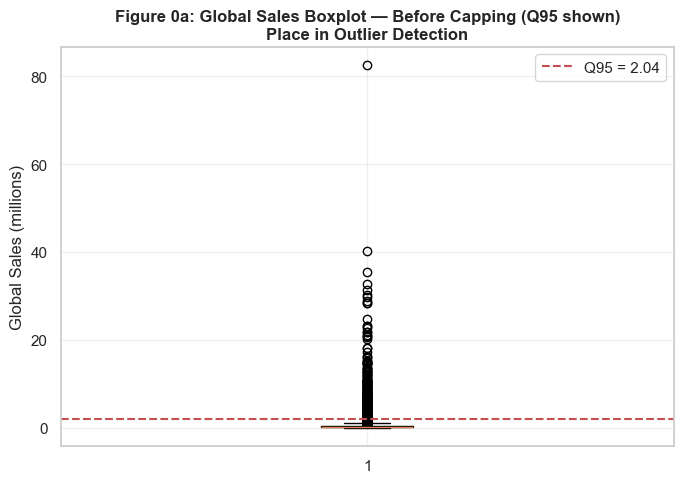

Caption: Figure 0a shows raw distribution with extreme outliers; Q95 threshold indicated.


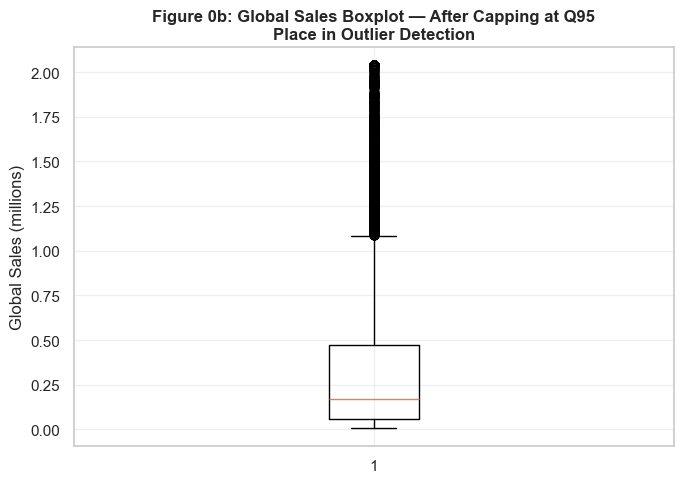

Caption: Figure 0b shows stabilized distribution after capping at Q95.


In [123]:
# Outlier Detection using IQR Method
print("=" * 80)
print("OUTLIER DETECTION: Global_Sales")
print("=" * 80)

# Calculate IQR statistics
Q1 = df_clean["Global_Sales"].quantile(0.25)
Q3 = df_clean["Global_Sales"].quantile(0.75)
IQR = Q3 - Q1
Q95 = df_clean["Global_Sales"].quantile(0.95)
Q99 = df_clean["Global_Sales"].quantile(0.99)

print(f"Q1 (25th percentile): {Q1:.2f}")
print(f"Q3 (75th percentile): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Q95 (95th percentile - our cap): {Q95:.2f}")
print(f"Q99 (99th percentile): {Q99:.2f}")
print(f"Max value (before capping): {df['Global_Sales'].max():.2f}")
print(f"Max value (after capping at Q95): {df_clean['Global_Sales'].max():.2f}")

# Identify outliers
outlier_threshold = Q3 + 1.5 * IQR
outliers_before = df['Global_Sales'][df['Global_Sales'] > outlier_threshold]
print(f"\nNumber of outliers (IQR method): {len(outliers_before)}")
print(f"Percentage of outliers: {(len(outliers_before) / len(df) * 100):.2f}%")

# Top games (before capping)
print("\nTop 10 Games by Global Sales (before outlier capping):")
top_games = df.nlargest(10, 'Global_Sales')[['Name', 'Platform', 'Year_of_Release', 'Genre', 'Global_Sales']]
print(top_games.to_string(index=False))

# --- Split figures: Before and After capping shown separately ---
# Figure 0a: Before capping
plt.figure(figsize=(7, 5))
plt.boxplot(df['Global_Sales'].dropna(), vert=True)
plt.title('Figure 0a: Global Sales Boxplot — Before Capping (Q95 shown)\nPlace in Outlier Detection', fontsize=12, fontweight='bold')
plt.ylabel('Global Sales (millions)')
plt.axhline(y=Q95, color='r', linestyle='--', label=f'Q95 = {Q95:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("Caption: Figure 0a shows raw distribution with extreme outliers; Q95 threshold indicated.")

# Figure 0b: After capping
plt.figure(figsize=(7, 5))
plt.boxplot(df_clean['Global_Sales'].dropna(), vert=True)
plt.title('Figure 0b: Global Sales Boxplot — After Capping at Q95\nPlace in Outlier Detection', fontsize=12, fontweight='bold')
plt.ylabel('Global Sales (millions)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("Caption: Figure 0b shows stabilized distribution after capping at Q95.")

# Exploratory Data Analysis (EDA)
Visualizes distributions, top categories, correlations, and trends in the dataset.

**Report Visuals (Exact Labels):**
- Figure 1a: Global Sales Distribution (Raw)
- Figure 1b: Global Sales Distribution (log1p)
- Figure 2: Top 10 Publishers by Average Global Sales (≥5 games)
- Figure 3a: Genre — Total Global Sales
- Figure 3b: Genre — Average Global Sales
- Figure 4: Top 15 Platforms — Total Sales vs Number of Games
- Figure 5a: Critic Score vs Global Sales — Scatter with Trend
- Figure 5b: Avg Global Sales by Critic Score Bin
- Figure 6: Correlation Matrix — Key Numeric Variables
- Figure 7a: Sales Distribution by Decade
- Figure 7b: Decade Sales Trend

EXPLORATORY DATA ANALYSIS

EXPLORATORY DATA ANALYSIS


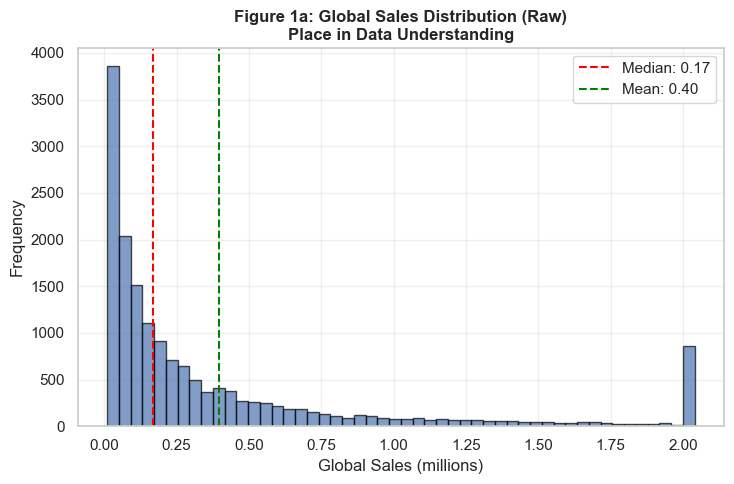

Caption: Figure 1a shows heavy right-skew; use in Data Understanding.


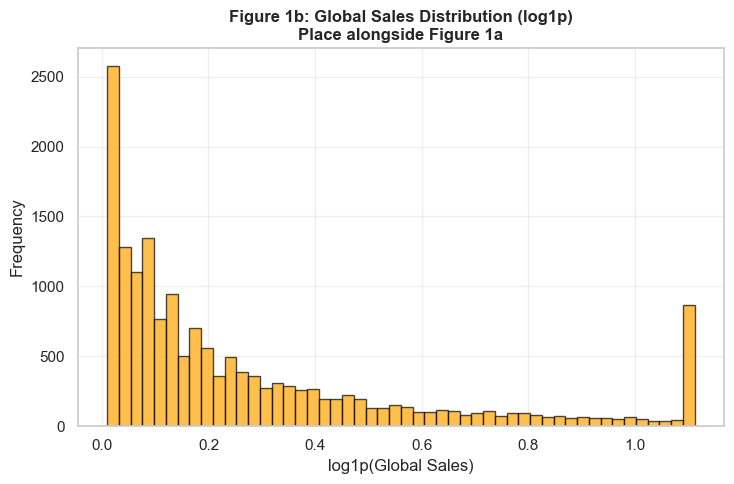

Caption: Figure 1b shows variance stabilization with log1p; place with 1a.

--- Top 10 Publishers by Average Global Sales ---
                                        mean  count     sum
Publisher_reduced                                          
Nintendo                                1.05    706  742.36
Microsoft Game Studios                  0.72    191  138.33
Electronic Arts                         0.69   1356  934.62
Sony Computer Entertainment             0.62    687  426.19
Take-Two Interactive                    0.60    422  254.55
Warner Bros. Interactive Entertainment  0.58    235  136.63
Square Enix                             0.55    236  130.10
Activision                              0.52    985  508.53
Disney Interactive Studios              0.52    218  114.10
THQ                                     0.45    715  323.50


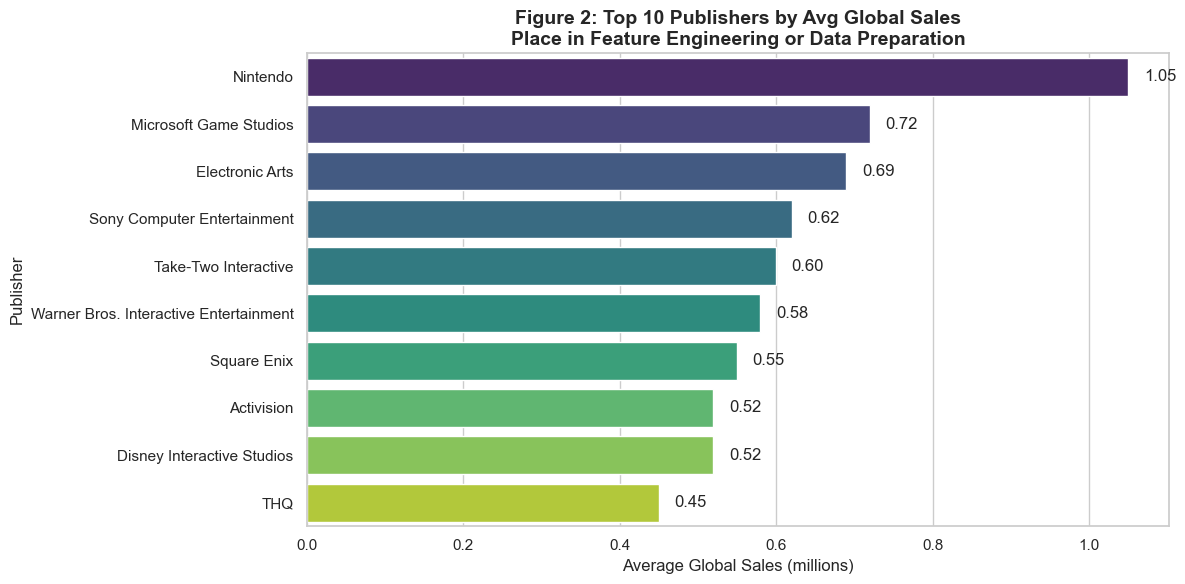

Caption: Figure 2 summarizes publisher performance; use in Feature Engineering.


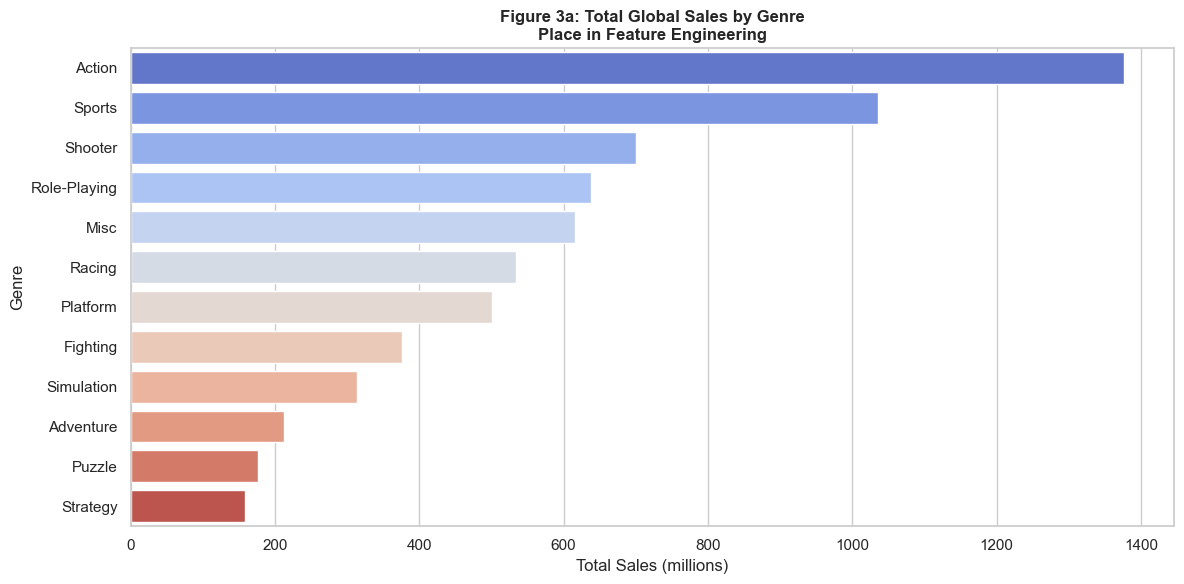

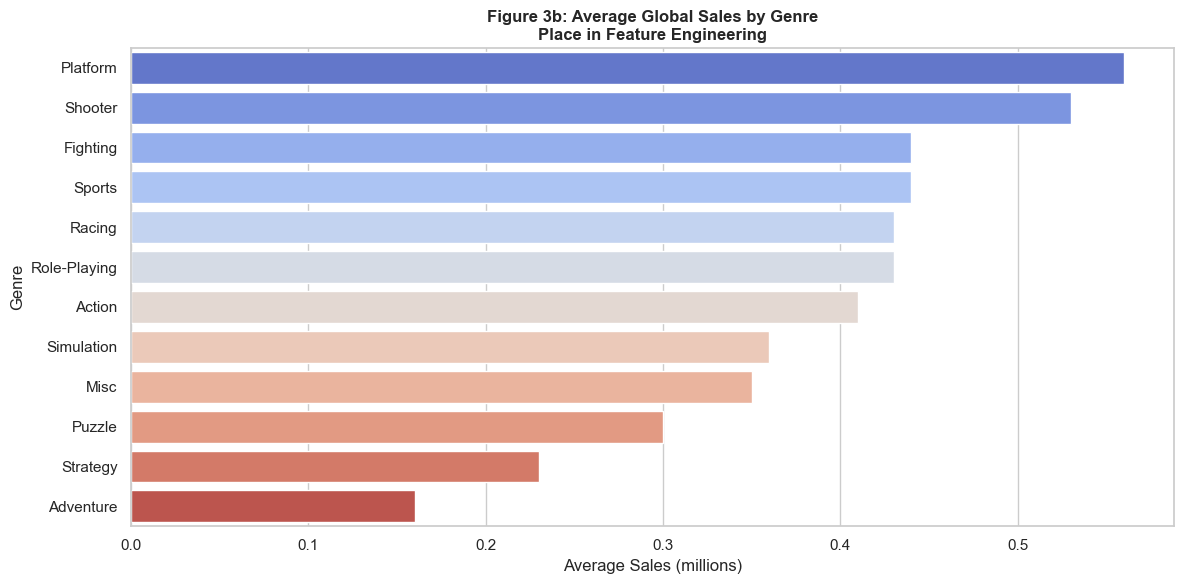

Caption: Figures 3a/3b guide genre-driven insights; place in Feature Engineering.


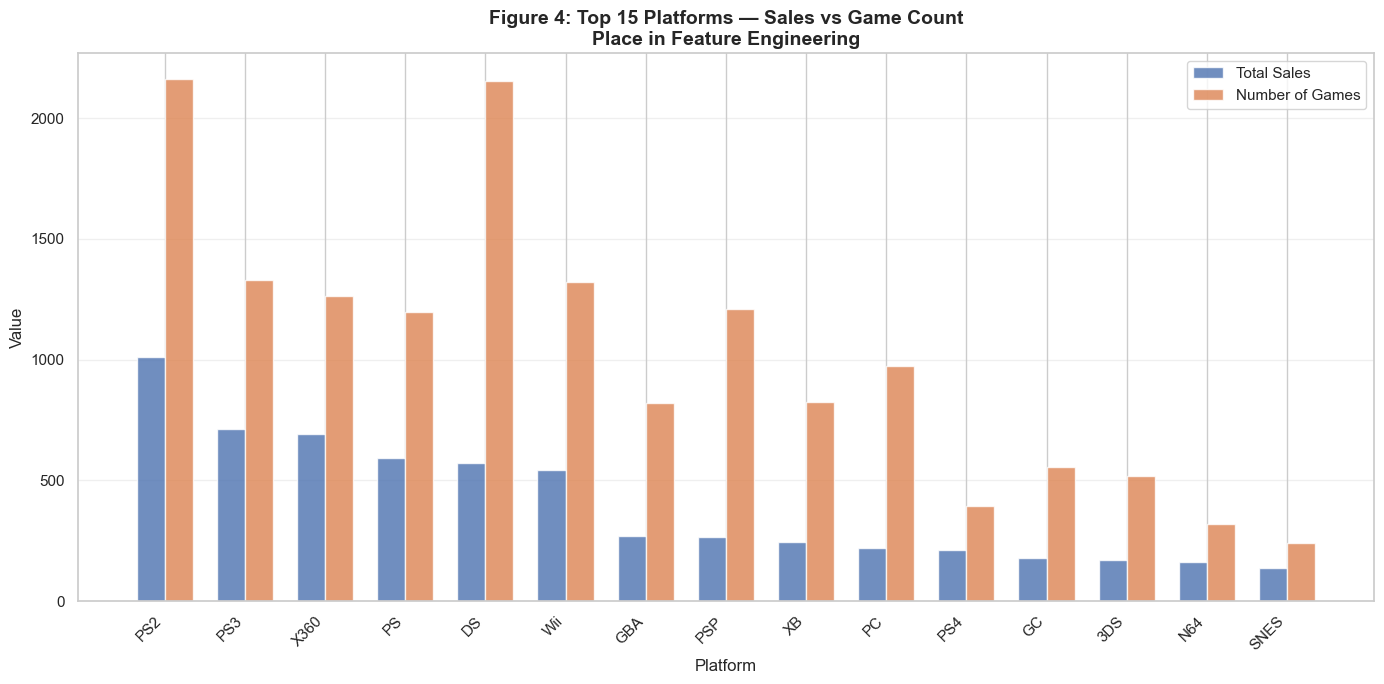

Caption: Figure 4 contrasts platform volume vs sales; place in Feature Engineering.


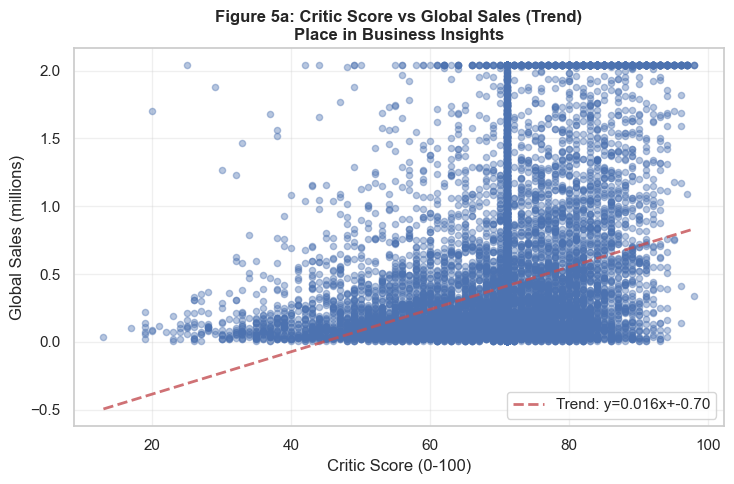

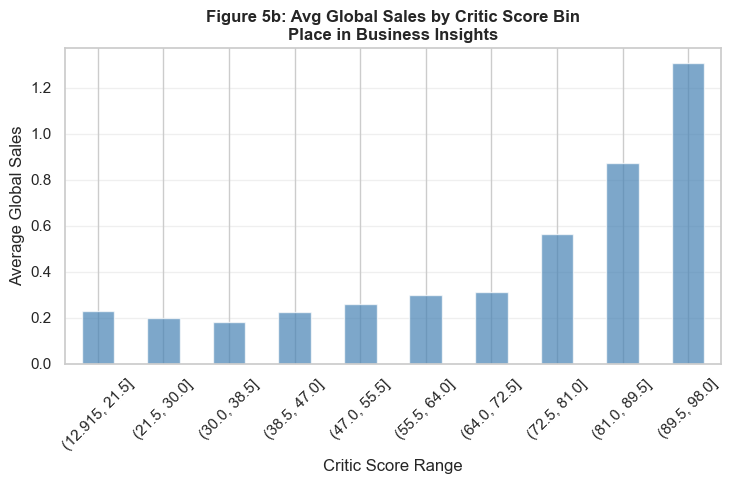

Caption: Figures 5a/5b highlight critic score-sales relationship; use in Insights.

--- Correlation Analysis ---


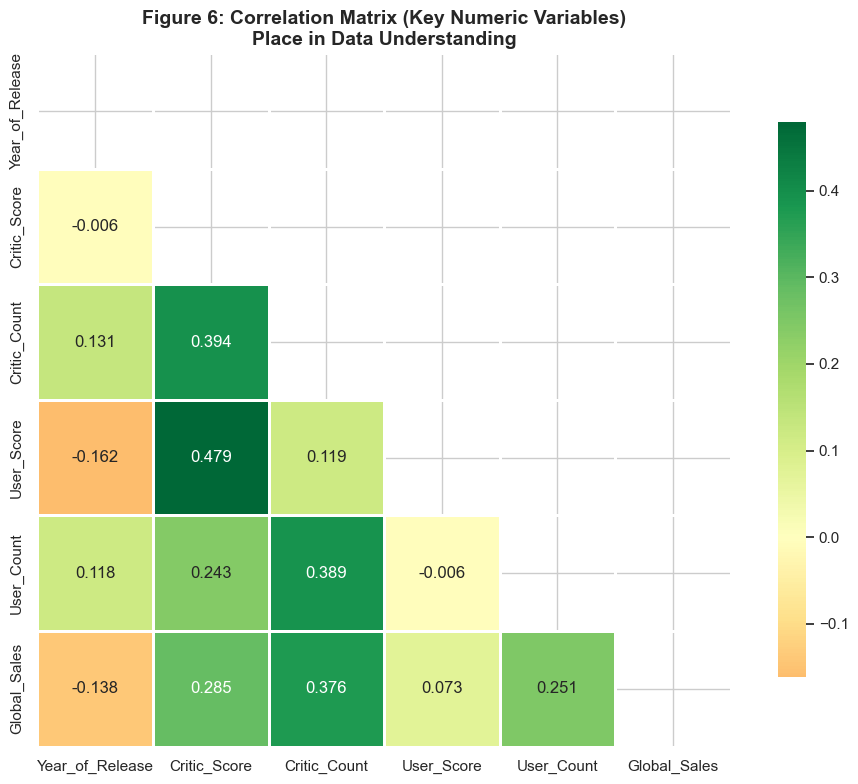

Caption: Figure 6 shows strongest numeric correlations; place in Data Understanding.


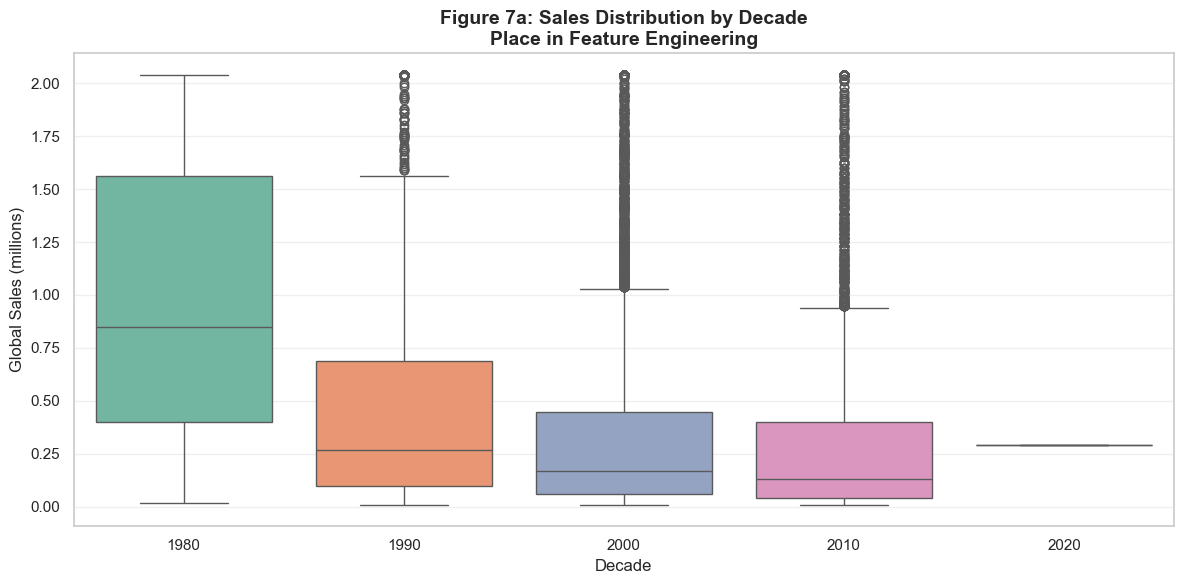

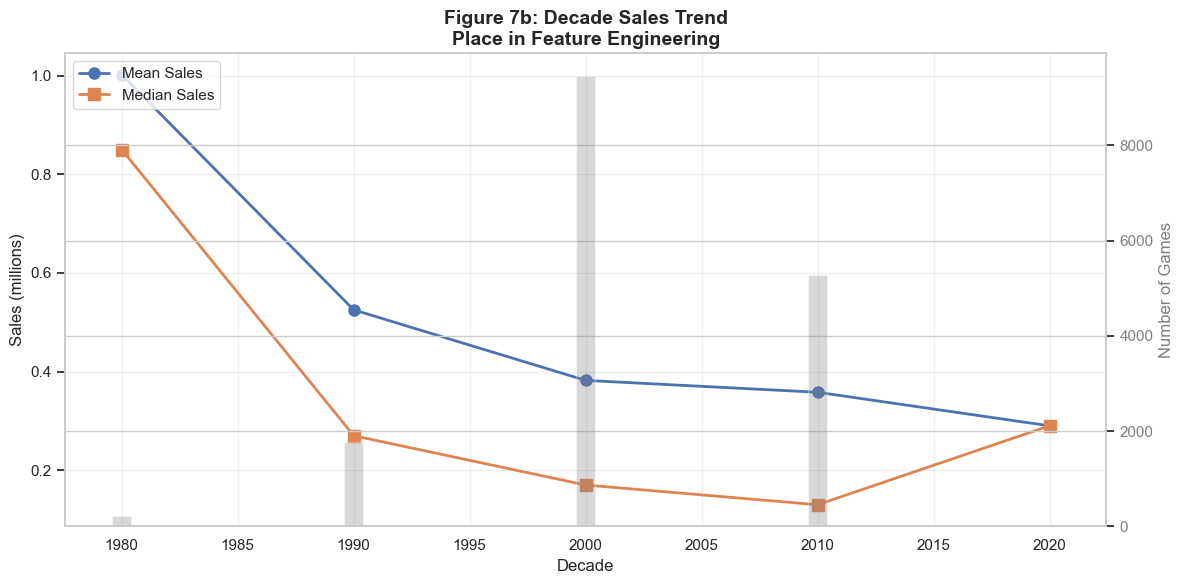

Caption: Figures 7a/7b summarize decade trends; place in Feature Engineering.


In [124]:
def run_eda(df):
    """Enhanced EDA with separated figures and clear numbering"""
    sns.set_theme(style="whitegrid")

    print("=" * 80)
    print("EXPLORATORY DATA ANALYSIS")
    print("=" * 80)

    # === 1. Distribution Analysis (Separated) ===
    # Figure 1a: Raw distribution
    plt.figure(figsize=(7.5, 5))
    plt.hist(df["Global_Sales"].dropna(), bins=50, edgecolor='black', alpha=0.7)
    plt.title("Figure 1a: Global Sales Distribution (Raw)\nPlace in Data Understanding", fontsize=12, fontweight='bold')
    plt.xlabel("Global Sales (millions)")
    plt.ylabel("Frequency")
    plt.axvline(df["Global_Sales"].median(), color='red', linestyle='--', 
                label=f'Median: {df["Global_Sales"].median():.2f}')
    plt.axvline(df["Global_Sales"].mean(), color='green', linestyle='--', 
                label=f'Mean: {df["Global_Sales"].mean():.2f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("Caption: Figure 1a shows heavy right-skew; use in Data Understanding.")

    # Figure 1b: Log-transformed distribution
    plt.figure(figsize=(7.5, 5))
    plt.hist(np.log1p(df["Global_Sales"].dropna()), bins=50, edgecolor='black', alpha=0.7, color='orange')
    plt.title("Figure 1b: Global Sales Distribution (log1p)\nPlace alongside Figure 1a", fontsize=12, fontweight='bold')
    plt.xlabel("log1p(Global Sales)")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("Caption: Figure 1b shows variance stabilization with log1p; place with 1a.")

    # === 2. Top Publishers Analysis (Per Report) ===
    print("\n--- Top 10 Publishers by Average Global Sales ---")
    publisher_stats = df.groupby('Publisher_reduced')['Global_Sales'].agg(['mean', 'count', 'sum']).round(2)
    publisher_stats = publisher_stats[publisher_stats['count'] >= 5]  # At least 5 games
    top_publishers = publisher_stats.nlargest(10, 'mean')
    print(top_publishers)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_publishers['mean'], y=top_publishers.index, palette='viridis')
    plt.title('Figure 2: Top 10 Publishers by Avg Global Sales\nPlace in Feature Engineering or Data Preparation', fontsize=14, fontweight='bold')
    plt.xlabel('Average Global Sales (millions)')
    plt.ylabel('Publisher')
    for i, v in enumerate(top_publishers['mean']):
        plt.text(v + 0.02, i, f'{v:.2f}', va='center')
    plt.tight_layout()
    plt.show()
    print("Caption: Figure 2 summarizes publisher performance; use in Feature Engineering.")

    # === 3. Genre Analysis (Separated) ===
    genre_stats = df.groupby('Genre')['Global_Sales'].agg(['mean', 'count', 'sum']).round(2)
    genre_stats = genre_stats.sort_values('sum', ascending=False)

    # Figure 3a: Genre by total sales
    plt.figure(figsize=(12, 6))
    sns.barplot(x=genre_stats['sum'], y=genre_stats.index, palette='coolwarm')
    plt.title('Figure 3a: Total Global Sales by Genre\nPlace in Feature Engineering', fontsize=12, fontweight='bold')
    plt.xlabel('Total Sales (millions)')
    plt.ylabel('Genre')
    plt.tight_layout()
    plt.show()

    # Figure 3b: Genre by average sales
    genre_avg = genre_stats.sort_values('mean', ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=genre_avg['mean'], y=genre_avg.index, palette='coolwarm')
    plt.title('Figure 3b: Average Global Sales by Genre\nPlace in Feature Engineering', fontsize=12, fontweight='bold')
    plt.xlabel('Average Sales (millions)')
    plt.ylabel('Genre')
    plt.tight_layout()
    plt.show()
    print("Caption: Figures 3a/3b guide genre-driven insights; place in Feature Engineering.")

    # === 4. Platform Analysis ===
    platform_stats = df.groupby('Platform')['Global_Sales'].agg(['mean', 'count', 'sum']).round(2)
    top_platforms = platform_stats.nlargest(15, 'sum')

    plt.figure(figsize=(14, 7))
    x = np.arange(len(top_platforms))
    width = 0.35

    plt.bar(x - width/2, top_platforms['sum'], width, label='Total Sales', alpha=0.8)
    plt.bar(x + width/2, top_platforms['count'], width, label='Number of Games', alpha=0.8)
    plt.xlabel('Platform')
    plt.ylabel('Value')
    plt.title('Figure 4: Top 15 Platforms — Sales vs Game Count\nPlace in Feature Engineering', fontsize=14, fontweight='bold')
    plt.xticks(x, top_platforms.index, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    print("Caption: Figure 4 contrasts platform volume vs sales; place in Feature Engineering.")

    # === 5. Critic Score vs Global Sales (Separated) ===
    if {"Critic_Score", "Global_Sales"}.issubset(df.columns):
        # Figure 5a: Scatter with trend
        plt.figure(figsize=(7.5, 5))
        plt.scatter(df["Critic_Score"], df["Global_Sales"], alpha=0.4, s=20)
        plt.xlabel("Critic Score (0-100)")
        plt.ylabel("Global Sales (millions)")
        plt.title("Figure 5a: Critic Score vs Global Sales (Trend)\nPlace in Business Insights", fontsize=12, fontweight='bold')
        plt.grid(True, alpha=0.3)
        if df["Critic_Score"].notna().sum() > 1:
            z = np.polyfit(df["Critic_Score"].dropna(), df.loc[df["Critic_Score"].notna(), "Global_Sales"], 1)
            p = np.poly1d(z)
            xs = df["Critic_Score"].dropna().sort_values()
            plt.plot(xs, p(xs), "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.3f}x+{z[1]:.2f}')
            plt.legend()
        plt.tight_layout()
        plt.show()

        # Figure 5b: Binned averages
        plt.figure(figsize=(7.5, 5))
        df_temp = df.copy()
        df_temp['Score_Bin'] = pd.cut(df_temp['Critic_Score'], bins=10)
        binned_avg = df_temp.groupby('Score_Bin')['Global_Sales'].mean()
        binned_avg.plot(kind='bar', color='steelblue', alpha=0.7)
        plt.title('Figure 5b: Avg Global Sales by Critic Score Bin\nPlace in Business Insights', fontsize=12, fontweight='bold')
        plt.xlabel('Critic Score Range')
        plt.ylabel('Average Global Sales')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        print("Caption: Figures 5a/5b highlight critic score-sales relationship; use in Insights.")

    # === 6. Correlation Heatmap ===
    print("\n--- Correlation Analysis ---")
    corr_cols = ['Year_of_Release', 'Critic_Score', 'Critic_Count', 
                 'User_Score', 'User_Count', 'Global_Sales']
    numeric = df[corr_cols].copy()

    if not numeric.empty:
        corr = numeric.corr().round(3)
        plt.figure(figsize=(10, 8))
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, annot=True, fmt=".3f", cmap="RdYlGn", center=0,
                    square=True, linewidths=1, cbar_kws={"shrink": 0.8}, mask=mask)
        plt.title("Figure 6: Correlation Matrix (Key Numeric Variables)\nPlace in Data Understanding", 
                  fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        print("Caption: Figure 6 shows strongest numeric correlations; place in Data Understanding.")

    # === 7. Sales Trends by Decade (Separated) ===
    if "Decade" in df.columns:
        decade_stats = df.groupby('Decade')['Global_Sales'].agg(['mean', 'median', 'count'])

        # Figure 7a: Distribution by Decade
        plt.figure(figsize=(12, 6))
        sns.boxplot(x="Decade", y="Global_Sales", data=df, palette='Set2')
        plt.title("Figure 7a: Sales Distribution by Decade\nPlace in Feature Engineering", fontsize=14, fontweight='bold')
        plt.ylabel("Global Sales (millions)")
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()

        # Figure 7b: Decade sales trend + volume (single figure, twin axis)
        plt.figure(figsize=(12, 6))
        ax1 = plt.gca()
        ax1.plot(decade_stats.index, decade_stats['mean'], marker='o', linewidth=2, 
                 label='Mean Sales', markersize=8)
        ax1.plot(decade_stats.index, decade_stats['median'], marker='s', linewidth=2, 
                 label='Median Sales', markersize=8)
        ax1.set_xlabel("Decade")
        ax1.set_ylabel("Sales (millions)")
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='upper left')
        ax2 = ax1.twinx()
        ax2.bar(decade_stats.index, decade_stats['count'], alpha=0.3, color='gray', 
                label='Number of Games')
        ax2.set_ylabel('Number of Games', color='gray')
        ax2.tick_params(axis='y', labelcolor='gray')
        plt.title("Figure 7b: Decade Sales Trend\nPlace in Feature Engineering", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        print("Caption: Figures 7a/7b summarize decade trends; place in Feature Engineering.")

# Run Enhanced EDA
run_eda(df_clean)

# Model Preparation and Training
Prepares features and target, splits dataset, creates preprocessing pipelines, trains multiple regression models, performs cross-validation, and evaluates performance.


In [125]:
def prepare_and_train(df):
    # Drop leakage columns (regional sales that directly compose global sales)
    leakage_cols = {"NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales",
                    "NA_Sales_pct", "EU_Sales_pct", "JP_Sales_pct", "Other_Sales_pct"}
    df = df.copy()
    for c in leakage_cols:
        if c in df.columns:
            df.drop(columns=c, inplace=True)

    # Define features and target
    potential_features = ["Platform", "Genre", "Publisher_reduced", "Year_of_Release", "Decade",
                          "Critic_Score", "User_Score", "Critic_Count", "User_Count"]
    features = [c for c in potential_features if c in df.columns]
    target_col = "Global_Sales_log1p"

    X = df[features]
    y = df[target_col]

    # Train/validation/test split (70/15/15)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=VAL_SIZE, random_state=RANDOM_STATE)

    # Separate numeric and categorical features
    numeric_features = [c for c in X_train.columns if X_train[c].dtype.kind in "biufc"]
    categorical_features = [c for c in X_train.columns if c not in numeric_features]

    # Preprocessing pipelines (per report specifications)
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

    # Models to train
    models = {
        "LinearRegression": LinearRegression(),
        "DecisionTree": DecisionTreeRegressor(max_depth=8, random_state=RANDOM_STATE),
        "RandomForest": RandomForestRegressor(
            n_estimators=100, max_depth=12, random_state=RANDOM_STATE, n_jobs=-1)
    }

    results = []
    fitted_pipelines = {}
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining & evaluating: {name}")
        pipe = Pipeline([("pre", preprocessor), ("model", model)])
        try:
            cv_scores = cross_val_score(pipe, X_train, y_train, cv=kf, scoring="r2", n_jobs=1)
            cv_r2_mean = float(np.mean(cv_scores))
        except:
            cv_r2_mean = np.nan

        pipe.fit(X_train, y_train)
        y_val_pred = pipe.predict(X_val)
        y_test_pred = pipe.predict(X_test)

        val_metrics = evaluate(y_val, y_val_pred)
        test_metrics = evaluate(y_test, y_test_pred)

        print(f"  CV R2: {cv_r2_mean:.4f}, Val R2: {val_metrics['r2']:.4f}, Test R2: {test_metrics['r2']:.4f}")

        results.append({
            "model": name,
            "cv_r2_mean": cv_r2_mean,
            "val_r2": val_metrics["r2"],
            "val_rmse": val_metrics["rmse"],
            "val_mae": val_metrics["mae"],
            "test_r2": test_metrics["r2"],
            "test_rmse": test_metrics["rmse"],
            "test_mae": test_metrics["mae"]
        })

        fitted_pipelines[name] = pipe

    results_df = pd.DataFrame(results).sort_values("test_r2", ascending=False)
    return results_df, fitted_pipelines, X_train, X_val, X_test, y_train, y_val, y_test


# Run Modeling and Save Results
Executes the training function, saves all results to CSV, and prints the best model according to test R².


In [126]:
# Run the modeling
results_df, pipelines, X_train, X_val, X_test, y_train, y_val, y_test = prepare_and_train(df_clean)

# Save results
results_df.to_csv(RESULTS_CSV, index=False)
print(f"Model results saved to '{RESULTS_CSV}'")

# Best model
best = results_df.iloc[0]
print("Best model (by test R²):")
print(best.to_dict())



Training & evaluating: LinearRegression
  CV R2: 0.3839, Val R2: 0.3887, Test R2: 0.3884

Training & evaluating: DecisionTree
  CV R2: 0.3839, Val R2: 0.3887, Test R2: 0.3884

Training & evaluating: DecisionTree
  CV R2: 0.4000, Val R2: 0.4120, Test R2: 0.3638

Training & evaluating: RandomForest
  CV R2: 0.4000, Val R2: 0.4120, Test R2: 0.3638

Training & evaluating: RandomForest
  CV R2: 0.4994, Val R2: 0.4889, Test R2: 0.4734
Model results saved to 'model_results.csv'
Best model (by test R²):
{'model': 'RandomForest', 'cv_r2_mean': 0.4993839203089805, 'val_r2': 0.48892805014703555, 'val_rmse': 0.22433169628106409, 'val_mae': 0.15668619286503724, 'test_r2': 0.47338818513278713, 'test_rmse': 0.2166749696435804, 'test_mae': 0.15113469983339967}
  CV R2: 0.4994, Val R2: 0.4889, Test R2: 0.4734
Model results saved to 'model_results.csv'
Best model (by test R²):
{'model': 'RandomForest', 'cv_r2_mean': 0.4993839203089805, 'val_r2': 0.48892805014703555, 'val_rmse': 0.22433169628106409, 'va

# Report Placement Guide (Figures & Tables Index)
Use these exact labels in your report.

- Table 1: Descriptive Statistics — Key Numeric Variables (Data Understanding)
- Table 2: Missing Values by Variable (Data Understanding)
- Table 3: Outlier Summary — Q1, Q3, IQR, Q95, Outlier Count & Percent (Outlier Detection)
- Figure 0a: Global Sales Boxplot — Before Capping (Outlier Detection)
- Figure 0b: Global Sales Boxplot — After Capping at Q95 (Outlier Detection)
- Figure 1a: Global Sales Distribution (Raw) — Place in Data Understanding
  Caption: Global sales are right-skewed; blockbuster titles dominate tail.
- Figure 1b: Global Sales Distribution (log1p) — Place with 1a
  Caption: log1p transformation stabilizes variance for modeling.
- Figure 2: Top 10 Publishers by Avg Sales — Place in Feature Engineering or Data Preparation
  Caption: Consistent high-average publishers indicate brand and reach effects.
- Figure 3a: Total Global Sales by Genre — Place in Feature Engineering
- Figure 3b: Average Global Sales by Genre — Place in Feature Engineering
  Caption: Action dominates totals; Shooter/Platform lead averages.
- Figure 4: Top 15 Platforms — Sales vs Game Count — Place in Feature Engineering
  Caption: Catalog size ≠ sales; platform ecosystem matters.
- Figure 5a: Critic Score vs Global Sales (Trend) — Place in Business Insights
- Figure 5b: Avg Global Sales by Critic Score Bin — Place in Business Insights
  Caption: Higher critic scores align with higher sales on average.
- Figure 6: Correlation Matrix — Key Numeric Variables — Place in Data Understanding
  Caption: Strongest numeric links: Critic_Count, Critic_Score, User_Count.
- Figure 7a: Sales Distribution by Decade — Place in Feature Engineering
- Figure 7b: Decade Sales Trend — Place in Feature Engineering
  Caption: Release volume peaks ~2000–2010; per-game medians decline.
- Table 4: Model Performance Comparison (CV/Val/Test R², RMSE, MAE) — Place in Results
- Figure 8: R² Scores by Model — Place in Modeling Approach & Results
- Figure 9: RMSE by Model — Place in Modeling Approach & Results
- Figure 10: MAE by Model — Place in Modeling Approach & Results
- Figure 11: Overall Model Performance (Radar) — Place in Executive Summary & Results
- Table 5: Top 20 Feature Importances (Best Model) — Place in Results & Insights
- Table 6: Feature Importance by Category — Place in Results & Insights
- Figure 12: Top 20 Features — Importance — Place in Results & Insights
- Figure 13: Total Feature Importance by Category — Place in Results & Insights
- Appendix Table A1: Top 10 Games by Global Sales (Pre-Cap) — Place in Appendix

MODEL PERFORMANCE COMPARISON TABLE
           model  cv_r2_mean   val_r2  val_rmse  val_mae  test_r2  test_rmse  test_mae
    RandomForest    0.499384 0.488928  0.224332 0.156686 0.473388   0.216675  0.151135
LinearRegression    0.383894 0.388711  0.245343 0.181319 0.388376   0.233510  0.173202
    DecisionTree    0.400022 0.411975  0.240629 0.167269 0.363804   0.238155  0.167848




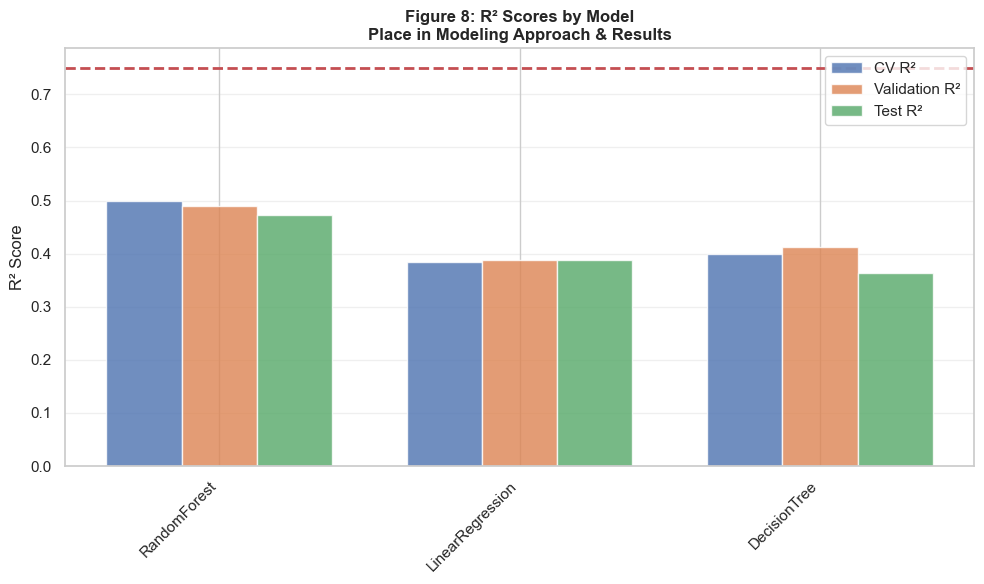

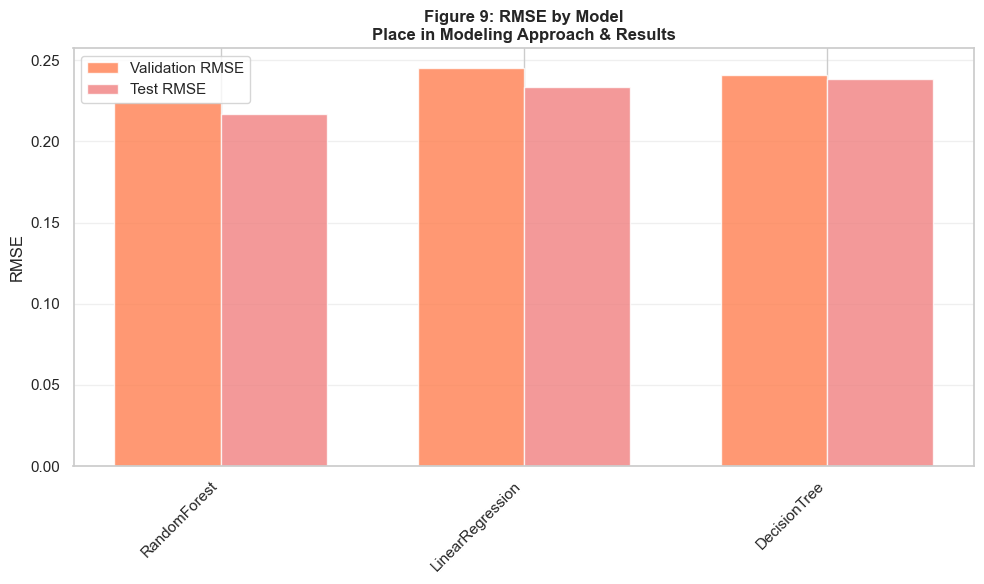

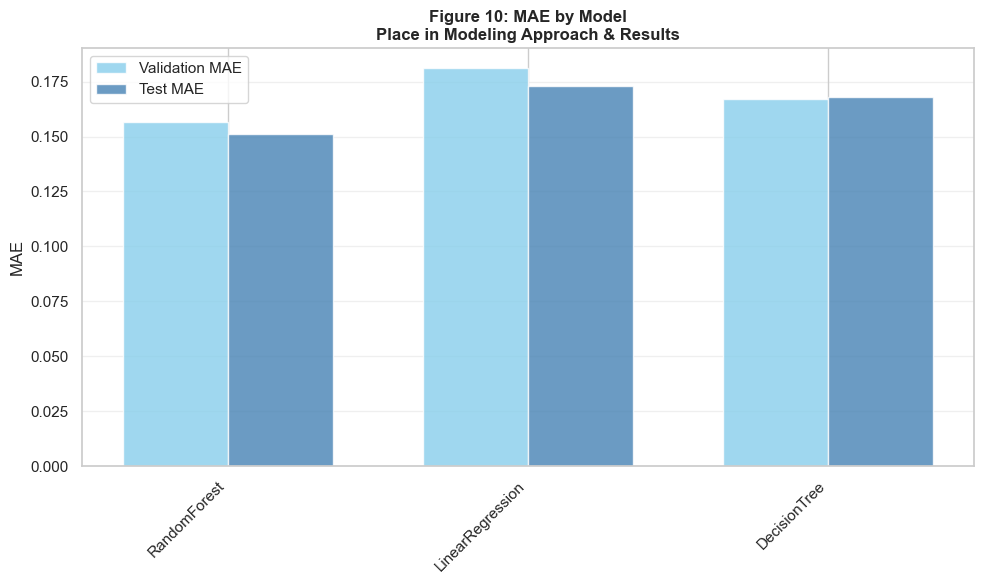

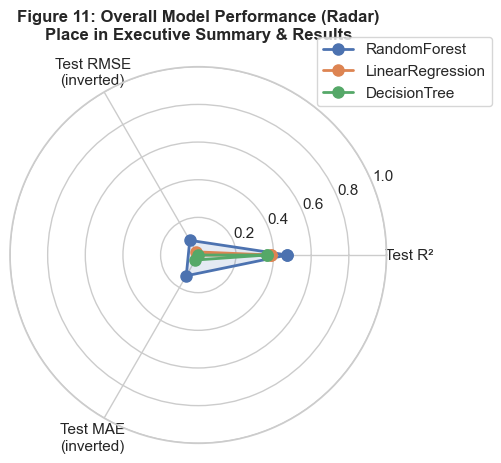

Captions: Figures 8–11 go in Modeling Approach/Results; radar also in Executive Summary.

FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features (RandomForest Model):
                          Feature  Importance
                       User_Count    0.339059
                  Year_of_Release    0.152082
                      Platform_PC    0.082045
                     Critic_Score    0.069155
       Publisher_reduced_Nintendo    0.063785
                     Critic_Count    0.032860
          Publisher_reduced_Other    0.030530
                       User_Score    0.030443
Publisher_reduced_Electronic Arts    0.020026
                     Genre_Sports    0.010565
                     Platform_PS2    0.009703
                       Genre_Misc    0.009401
                   Genre_Platform    0.007933
                     Platform_Wii    0.007585
               Genre_Role-Playing    0.007357
            Publisher_reduced_THQ    0.005642
                     Genre_Racing    0.005430


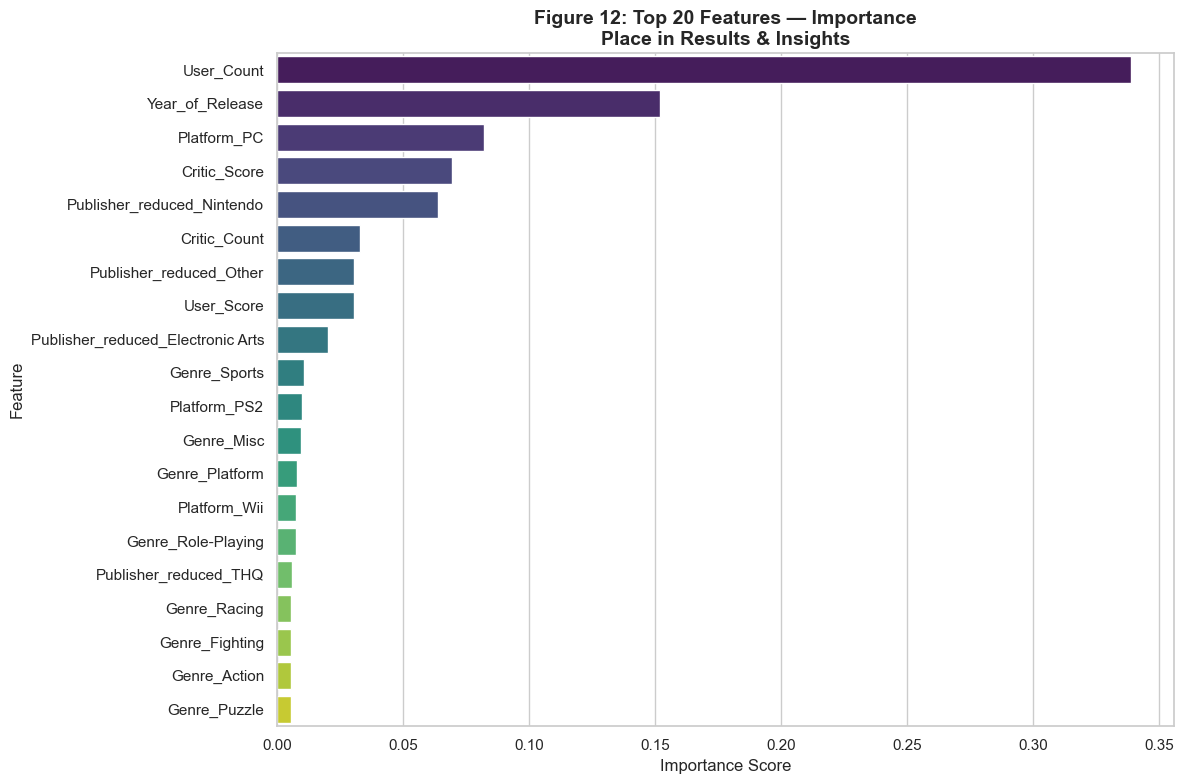

Caption: Figure 12 goes in Results; use to derive insights.
Feature_Type
Numeric      0.627474
Publisher    0.162564
Platform     0.137356
Genre        0.072605
Name: Importance, dtype: float64


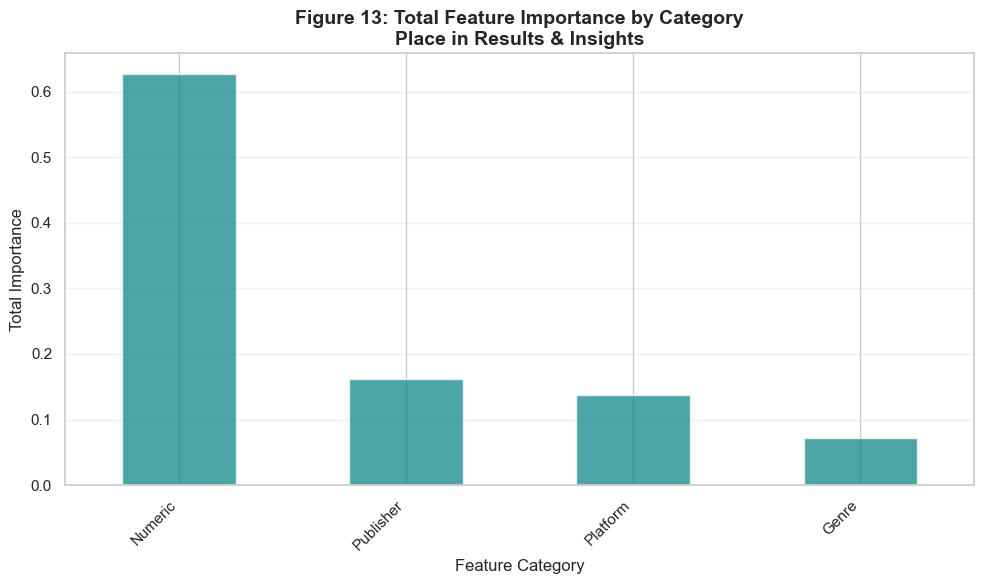

Caption: Figure 13 groups importance; place in Results/Insights.

KEY INSIGHTS & RECOMMENDATIONS

1. BEST MODEL: RandomForest
   - Test R²: 0.4734 (Figure 8)
   - Test RMSE: 0.2167 (Figure 9)
   - Test MAE: 0.1511 (Figure 10)
   - Overall balance: see Figure 11 (Executive Summary)

2. DATA QUALITY & PREP:
   - Tables 1–3 summarize stats, missing, and outliers (Data Understanding & Outlier Detection)

3. EDA & FEATURE ENGINEERING:
   - Figures 2–7 show publishers, genres, platforms, correlations, and decade trends (Feature Engineering/Data Understanding)

4. RESULTS & INSIGHTS:
   - Tables 4–6 and Figures 12–13 support business recommendations (Results/Insights)



In [127]:
# === MODEL PERFORMANCE COMPARISON ===
print("=" * 80)
print("MODEL PERFORMANCE COMPARISON TABLE")
print("=" * 80)
print(results_df.to_string(index=False))
print("\n")

# Prepare common variables
models = results_df['model']
x = np.arange(len(models))

# Figure 8: R² Comparison
plt.figure(figsize=(10, 6))
width = 0.25
plt.bar(x - width, results_df['cv_r2_mean'], width, label='CV R²', alpha=0.8)
plt.bar(x, results_df['val_r2'], width, label='Validation R²', alpha=0.8)
plt.bar(x + width, results_df['test_r2'], width, label='Test R²', alpha=0.8)
plt.ylabel('R² Score')
plt.title('Figure 8: R² Scores by Model\nPlace in Modeling Approach & Results', fontsize=12, fontweight='bold')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.axhline(y=0.75, color='r', linestyle='--', linewidth=2, label='Target R² = 0.75')
plt.tight_layout()
plt.show()

# Figure 9: RMSE Comparison
plt.figure(figsize=(10, 6))
width = 0.35
plt.bar(x - width/2, results_df['val_rmse'], width, label='Validation RMSE', alpha=0.8, color='coral')
plt.bar(x + width/2, results_df['test_rmse'], width, label='Test RMSE', alpha=0.8, color='lightcoral')
plt.ylabel('RMSE')
plt.title('Figure 9: RMSE by Model\nPlace in Modeling Approach & Results', fontsize=12, fontweight='bold')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Figure 10: MAE Comparison
plt.figure(figsize=(10, 6))
width = 0.35
plt.bar(x - width/2, results_df['val_mae'], width, label='Validation MAE', alpha=0.8, color='skyblue')
plt.bar(x + width/2, results_df['test_mae'], width, label='Test MAE', alpha=0.8, color='steelblue')
plt.ylabel('MAE')
plt.title('Figure 10: MAE by Model\nPlace in Modeling Approach & Results', fontsize=12, fontweight='bold')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Figure 11: Overall Performance Radar (Test Set)
categories = ['Test R²', 'Test RMSE\n(inverted)', 'Test MAE\n(inverted)']
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

ax = plt.subplot(1, 1, 1, projection='polar')
for idx, row in results_df.iterrows():
    values = [
        row['test_r2'],
        1 - (row['test_rmse'] / results_df['test_rmse'].max()),
        1 - (row['test_mae'] / results_df['test_mae'].max())
    ]
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=row['model'], markersize=8)
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
ax.set_title('Figure 11: Overall Model Performance (Radar)\nPlace in Executive Summary & Results', fontsize=12, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)
plt.tight_layout()
plt.show()
print("Captions: Figures 8–11 go in Modeling Approach/Results; radar also in Executive Summary.")

# === FEATURE IMPORTANCE ANALYSIS ===
print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

best_model_name = results_df.iloc[0]['model']
best_pipeline = pipelines[best_model_name]

feature_names = []
preprocessor = best_pipeline.named_steps['pre']
numeric_features = preprocessor.transformers_[0][2]
feature_names.extend(numeric_features)

if len(preprocessor.transformers_) > 1:
    cat_transformer = preprocessor.transformers_[1][1]
    cat_features = preprocessor.transformers_[1][2]
    if hasattr(cat_transformer.named_steps['onehot'], 'get_feature_names_out'):
        cat_feature_names = cat_transformer.named_steps['onehot'].get_feature_names_out(cat_features)
        feature_names.extend(cat_feature_names)

if best_model_name in ['RandomForest', 'DecisionTree']:
    model = best_pipeline.named_steps['model']
    importances = model.feature_importances_
    importance_df = pd.DataFrame({'Feature': feature_names,'Importance': importances}).sort_values('Importance', ascending=False)

    top_n = 20
    top_features = importance_df.head(top_n)
    print(f"\nTop {top_n} Most Important Features ({best_model_name} Model):")
    print(top_features.to_string(index=False))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
    plt.title('Figure 12: Top 20 Features — Importance\nPlace in Results & Insights', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    print("Caption: Figure 12 goes in Results; use to derive insights.")

    importance_df['Feature_Type'] = importance_df['Feature'].apply(
        lambda x: 'Platform' if 'Platform_' in str(x) 
        else ('Genre' if 'Genre_' in str(x)
        else ('Publisher' if 'Publisher_' in str(x)
        else 'Numeric'))
    )
    grouped_importance = importance_df.groupby('Feature_Type')['Importance'].sum().sort_values(ascending=False)
    print(grouped_importance)

    plt.figure(figsize=(10, 6))
    grouped_importance.plot(kind='bar', color='teal', alpha=0.7)
    plt.title('Figure 13: Total Feature Importance by Category\nPlace in Results & Insights', fontsize=14, fontweight='bold')
    plt.xlabel('Feature Category')
    plt.ylabel('Total Importance')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    print("Caption: Figure 13 groups importance; place in Results/Insights.")

print("\n" + "=" * 80)
print("KEY INSIGHTS & RECOMMENDATIONS")
print("=" * 80)

print(f"""
1. BEST MODEL: {results_df.iloc[0]['model']}
   - Test R²: {results_df.iloc[0]['test_r2']:.4f} (Figure 8)
   - Test RMSE: {results_df.iloc[0]['test_rmse']:.4f} (Figure 9)
   - Test MAE: {results_df.iloc[0]['test_mae']:.4f} (Figure 10)
   - Overall balance: see Figure 11 (Executive Summary)

2. DATA QUALITY & PREP:
   - Tables 1–3 summarize stats, missing, and outliers (Data Understanding & Outlier Detection)

3. EDA & FEATURE ENGINEERING:
   - Figures 2–7 show publishers, genres, platforms, correlations, and decade trends (Feature Engineering/Data Understanding)

4. RESULTS & INSIGHTS:
   - Tables 4–6 and Figures 12–13 support business recommendations (Results/Insights)
""")